<a href="https://colab.research.google.com/github/TarekAzzouni/Baterries-ML-Lithium-Ions-01/blob/main/Deep_learning_for_Regression_in_the_HNEI_dataset_part2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import numpy as np 
import pandas as pd
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import norm, boxcox
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
from scipy import stats

import tensorflow as tf
import matplotlib.pyplot as plt

import io
import requests


from warnings import simplefilter
import warnings
# ignore all warnings
simplefilter(action='ignore')

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [112]:
url="https://www.batteryarchive.org/data/HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a_timeseries.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [113]:
df.head()

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,2013-05-22 11:46:56,30.014,1.0,0.000,3.779,0.0,0.000,0.0,0.000,NaN,NaN
1,2013-05-22 11:47:26,59.999,1.0,0.000,3.779,0.0,0.000,0.0,0.000,NaN,NaN
2,2013-05-22 11:47:33,67.294,1.0,-1.398,3.670,0.0,0.001,0.0,0.005,NaN,NaN
3,2013-05-22 11:47:41,74.303,1.0,-1.398,3.664,0.0,0.004,0.0,0.015,NaN,NaN
4,2013-05-22 11:47:48,81.310,1.0,-1.399,3.659,0.0,0.006,0.0,0.025,NaN,NaN


In [114]:
train = df[df['Cycle_Index'] == 1 ]
train

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,2013-05-22 11:46:56,30.014,1.0,0.000,3.779,0.000,0.000,0.00,0.000,NaN,NaN
1,2013-05-22 11:47:26,59.999,1.0,0.000,3.779,0.000,0.000,0.00,0.000,NaN,NaN
2,2013-05-22 11:47:33,67.294,1.0,-1.398,3.670,0.000,0.001,0.00,0.005,NaN,NaN
3,2013-05-22 11:47:41,74.303,1.0,-1.398,3.664,0.000,0.004,0.00,0.015,NaN,NaN
4,2013-05-22 11:47:48,81.310,1.0,-1.399,3.659,0.000,0.006,0.00,0.025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1951,2013-05-22 15:49:05,14558.462,1.0,0.000,4.342,2.869,0.000,11.58,0.000,NaN,NaN
1952,2013-05-22 15:49:35,14588.447,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN
1953,2013-05-22 15:50:05,14618.462,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN
1954,2013-05-22 15:50:34,14648.447,1.0,0.000,4.341,2.869,0.000,11.58,0.000,NaN,NaN


In [115]:
test = df[df['Cycle_Index'] == 2 ]

In [116]:
def get_data():
    #get train data
    #train_data_path ='train.csv'
    train = df[df['Cycle_Index'] == 1 ]
    
    #get test data
    #test_data_path ='test.csv'
    test = df[df['Cycle_Index'] == 2 ]
    
    return train , test



In [117]:
#rename the charge capacity
train = train.rename(columns={'Charge_Capacity (Ah)': 'Charge_Capacity'})
test = test.rename(columns={'Charge_Capacity (Ah)': 'Charge_Capacity'})

In [118]:
train1 = train.drop(['Environment_Temperature (C)','Cell_Temperature (C)','Date_Time'],axis=1)
test1 = test.drop(['Environment_Temperature (C)','Cell_Temperature (C)','Date_Time'],axis=1)

In [119]:
train1

,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity,Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
0,30.014,1.0,0.000,3.779,0.000,0.000,0.00,0.000
1,59.999,1.0,0.000,3.779,0.000,0.000,0.00,0.000
2,67.294,1.0,-1.398,3.670,0.000,0.001,0.00,0.005
3,74.303,1.0,-1.398,3.664,0.000,0.004,0.00,0.015
4,81.310,1.0,-1.399,3.659,0.000,0.006,0.00,0.025
...,...,...,...,...,...,...,...,...
1951,14558.462,1.0,0.000,4.342,2.869,0.000,11.58,0.000
1952,14588.447,1.0,0.000,4.341,2.869,0.000,11.58,0.000
1953,14618.462,1.0,0.000,4.341,2.869,0.000,11.58,0.000
1954,14648.447,1.0,0.000,4.341,2.869,0.000,11.58,0.000


In [120]:
Col_target = ["Charge_Capacity"]
target = train1[Col_target]

In [121]:
train1.columns

Index(['Test_Time (s)', 'Cycle_Index', 'Current (A)', 'Voltage (V)',
       'Charge_Capacity', 'Discharge_Capacity (Ah)', 'Charge_Energy (Wh)',
       'Discharge_Energy (Wh)'],
      dtype='object')

In [122]:


def get_combined_data():
  #reading train data
  train1 , test1 = get_data()
  #train.drop(['Charge_Capacity'],axis = 1 , inplace = True)

  combined = train1.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['Environment_Temperature (C)', 'Cell_Temperature (C)'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [123]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559 entries, 0 to 4558
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    4559 non-null   int64  
 1   Date_Time                4559 non-null   object 
 2   Test_Time (s)            4559 non-null   float64
 3   Cycle_Index              4559 non-null   float64
 4   Current (A)              4559 non-null   float64
 5   Voltage (V)              4559 non-null   float64
 6   Charge_Capacity (Ah)     1956 non-null   float64
 7   Discharge_Capacity (Ah)  4559 non-null   float64
 8   Charge_Energy (Wh)       4559 non-null   float64
 9   Discharge_Energy (Wh)    4559 non-null   float64
 10  Charge_Capacity          2603 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 391.9+ KB


In [124]:
def get_cols_with_no_nans(df1,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df1.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df1.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df1
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df1[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [125]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [126]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 8
Number of nun-numerical columns with no nan values : 1


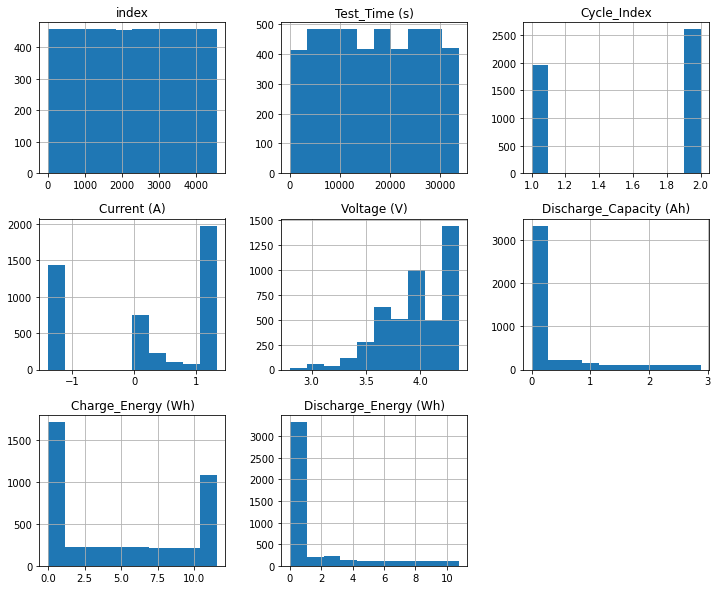

In [127]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

***One Hot Encode The Categorical Features :***

We will encode the categorical features using one hot encoding

In [128]:
def oneHotEncode(df1,colNames):
    for col in colNames:
        if( df1[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df1[col],prefix=col)
            df1 = pd.concat([df1,dummies],axis=1)

            #drop the encoded column
            df1.drop([col],axis = 1 , inplace=True)
    return df1

In [129]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 9 columns before encoding categorical features
There are 4566 columns after encoding categorical features


Now, split back combined dataFrame to training data and test data

In [130]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 

In [131]:
train, test = split_combined()

# Second : Make the Deep Neural Network


*   Define a sequential model
*   Add some dense layers
*   Use 'relu' as the activation function in the hidden layers
*   Use a 'normal' initializer as the kernal_intializer

```
 Initializers define the way to set the initial random weights of Keras layers.
```
*   We will use mean_absolute_error as a loss function
*   Define the output layer with only one node
*   Use 'linear 'as the activation function for the output layer







In [134]:
NN_model = Sequential()

**The input Layer**

In [135]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

**The Hidden Layers**


In [136]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

**The output layer**

In [137]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

**Compile the network**

In [138]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               584576    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 749,441
Trainable params: 749,441
Non-trainable params: 0
_________________________________________________________________


**Define a checkpoint callback**

In [147]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Third : Train the model :

In [148]:
NN_model.fit(train, target, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/100
37/37 [==============================] - 0s 10ms/step - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347

Epoch 00001: val_loss improved from inf to 0.03467, saving model to Weights-001--0.03467.hdf5
Epoch 2/100
37/37 [==============================] - 0s 10ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0488 - val_mean_absolute_error: 0.0488

Epoch 00002: val_loss did not improve from 0.03467
Epoch 3/100
37/37 [==============================] - 0s 10ms/step - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0397 - val_mean_absolute_error: 0.0397

Epoch 00003: val_loss did not improve from 0.03467
Epoch 4/100
37/37 [==============================] - 0s 10ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236

Epoch 00004: val_loss improved from 0.03467 to 0.02356, saving model to Weights-004--0.02356.hdf5
Epoch 5/100
37/37 [===========================

In [149]:
# Load wights file of the best model :
wights_file = 'Weights-478--18738.19831.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

OSError: ignored